# Files

In [ ]:
!pip install tqdm
!pip install node2vec
!pip install demoji

!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_tree_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_label_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_source_tweet_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_vectors.npy
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_graph.graphml
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/embeddings.pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.

In [ ]:
import pandas as pd

# Read data from CSV files
twitter15_tree_df = pd.read_csv('./twitter15_tree_data.csv')
twitter15_label_df = pd.read_csv('./twitter15_label_data.csv')
twitter15_source_tweet_df = pd.read_csv('./twitter15_source_tweet_data.csv')


In [ ]:
twitter15_source_tweet_df['content']

0       🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...
1       an open letter to trump voters from his top st...
2       "america is a nation of second chances" —@potu...
3       brandon marshall visits and offers advice, sup...
4       rip elly may clampett: so sad to learn #beverl...
                              ...                        
1485    .@potus just announced new reforms to address ...
1486                      “after school satan clubs”? URL
1487    breaking news: according to documents released...
1488                     ebola vaccines? URL #news #today
1489    concerned airport passenger suits up in homema...
Name: content, Length: 1490, dtype: object

Clean Dataset

In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import re
import string
import demoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def remove_punctuation(text):
    return re.sub(r'[^A-Za-z0-9\s]+', '', text)

def remove_url_word(text):
    return text.replace("URL", "")

def remove_emojis(text):
    return demoji.replace(text, '')

def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def clean_text(text):
    text = remove_url_word(text)
    text = remove_punctuation(text)
    text = remove_emojis(text)
    text = remove_stop_words(text)
    text = lemmatize_text(text)
    return text

# Apply the cleaning function to the DataFrame
twitter15_source_tweet_df['cleaned_content'] = twitter15_source_tweet_df['content'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
twitter15_source_tweet_df['cleaned_content']

0       ca kkk grand wizard endorses hillaryclinton ne...
1       open letter trump voter top strategistturnedde...
2       america nation second chance potus new reform ...
3       brandon marshall visit offer advice support br...
4       rip elly may clampett sad learn beverlyhillbil...
                              ...                        
1485    potus announced new reform address overuse sol...
1486                                    school satan club
1487    breaking news according document released pres...
1488                             ebola vaccine news today
1489    concerned airport passenger suit homemade hazm...
Name: cleaned_content, Length: 1490, dtype: object

In [ ]:
path = "/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/pretrained/glove.6B.300d.txt"

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

def load_glove_embeddings(file_path):
    word_to_idx = {}
    embeddings = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_to_idx[word] = idx
            embeddings.append(vector)
    return word_to_idx, np.stack(embeddings)

word_to_idx, embedding_matrix = load_glove_embeddings(path)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset


class TwitterDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.texts = texts
        self.word_to_idx = word_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded_text = np.zeros((self.max_length, 300), dtype=np.float32)
        words = text.split()[:self.max_length]
        for i, word in enumerate(words):
            if word in self.word_to_idx:
                encoded_text[i] = embedding_matrix[self.word_to_idx[word]]

        return torch.tensor(encoded_text)

texts = list(twitter15_source_tweet_df['content'])
dataset = TwitterDataset(texts, word_to_idx)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Example processing loop
model_outputs = []
for batch in tqdm(dataloader):

    model_outputs.append(batch)

all_outputs = torch.cat(model_outputs, dim=0)



100%|██████████| 94/94 [00:00<00:00, 1032.29it/s]


In [ ]:
model_outputs = []
deberta_model.eval()
from tqdm import tqdm
for batch in tqdm(dataloader):
    batch = {key: val.to(device) for key, val in batch.items()}

    with torch.no_grad():
        outputs = deberta_model(**batch)
        model_outputs.append(outputs)

all_outputs = {
    key: torch.cat([getattr(output, key) for output in model_outputs], dim=0)
    for key in model_outputs[0].keys()
}

100%|██████████| 94/94 [00:06<00:00, 13.50it/s]


In [ ]:
print(all_outputs.shape)

torch.Size([1490, 64, 300])


In [ ]:
import numpy as np
embs = all_outputs.cpu()
np.save('./twitter_15_glove_new_clean', embs.numpy())

In [ ]:
twitter15_vectors = np.load('./twitter_15_glove_new_clean.npy')
twitter15_vectors.shape

(1490, 64, 300)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp ./twitter_15_glove_new_clean.npy "/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/datas/embs"

# CODE

In [ ]:
!pip install tqdm
!pip install node2vec
!pip install demoji

!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_tree_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_label_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_source_tweet_data.csv
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_vectors.npy
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_graph.graphml.xml
!wget https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/embeddings.pickle


--2024-06-16 23:51:19--  https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_tree_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41267063 (39M) [text/plain]
Saving to: ‘twitter15_tree_data.csv.1’

twitter15_tree_data 100%[===================>]  39.35M  --.-KB/s    in 0.08s   

2024-06-16 23:51:20 (468 MB/s) - ‘twitter15_tree_data.csv.1’ saved [41267063/41267063]

--2024-06-16 23:51:20--  https://raw.githubusercontent.com/dianacotelin/fakenews/main/drive-download-20240527T175238Z-001/twitter15_label_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

In [ ]:
!ls "/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/datas/embs/"
!cp "/content/drive/MyDrive/[Licenta] Maria-Diana COTELIN - Network-aware Fake News Mitigation/datas/embs/twitter_15_glove_new_clean.npy" ./twitter_15_glove_new_clean.npy

twitter_15_deb_new_clean.npy  twitter_15_glove_new_clean.npy  twitter_16_deb_new_clean.npy


In [ ]:
import pandas as pd
import torch
from transformers import DebertaTokenizer, DebertaModel
import numpy as np
import networkx as nx
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import DebertaModel, DebertaTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
twitter15_tree_df = pd.read_csv('./twitter15_tree_data.csv')
twitter15_label_df = pd.read_csv('./twitter15_label_data.csv')
twitter15_source_tweet_df = pd.read_csv('./twitter15_source_tweet_data.csv')

twitter15_vectors = np.load('./twitter_15_glove_new_clean.npy')

G = nx.DiGraph()
G = nx.read_graphml('./twitter15_graph.graphml.xml')

import pickle
with open('./embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)

 22%|██▎       | 9/40 [08:28<29:10, 56.46s/it, Validation Loss:=1.3872, Validation Accuracy:=0.2483]


In [ ]:
glov_emb = {}
n2v_emb = {}
label = {}
for idx in range(len(twitter15_vectors)):
  glov_emb[twitter15_source_tweet_df['source_tweet_id'][idx]] = twitter15_vectors[idx]
  n2v_emb[twitter15_source_tweet_df['source_tweet_id'][idx]] = embeddings[str(twitter15_source_tweet_df['source_tweet_id'][idx])]

print(len(glov_emb))
print(len(n2v_emb))

1490
1490


In [ ]:
labels = twitter15_label_df['label'].tolist()
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
#####
glov_emb_array = np.array(list(glov_emb.values()))
n2v_emb_array = np.array(list(n2v_emb.values()))

# Check if arrays have the same length
assert glov_emb_array.shape[0] == n2v_emb_array.shape[0], "Arrays have different lengths!"

# Split arrays into training and testing sets
glov_train, glov_test, n2v_train, n2v_test, y_train, y_test = train_test_split(glov_emb_array, n2v_emb_array, encoded_labels, test_size=0.2, random_state=42)
#####
X_train, X_test, y_train, y_test = train_test_split(twitter15_vectors, encoded_labels, test_size=0.2, random_state=42)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

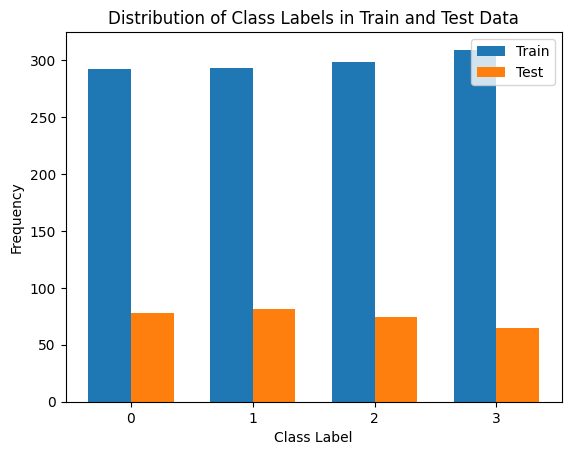

In [ ]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

# Create bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(train_classes))
train_bars = ax.bar(index, train_counts, bar_width, label='Train')
test_bars = ax.bar(index + bar_width, test_counts, bar_width, label='Test')

ax.set_xlabel('Class Label')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Class Labels in Train and Test Data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(train_classes)
ax.legend()

plt.show()

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold


def train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_val, n2v_val, y_val, batch_size, num_epochs):
    train_bar = tqdm(total=num_epochs, position=0, leave=True)
    for epoch in range(num_epochs):
        model.to("cuda")
        model.train()
        running_loss = 0.0
        for i in range(0, len(glov_train), batch_size):
            inputs_deberta = torch.tensor(glov_train[i:i+batch_size], dtype=torch.float32).to("cuda")
            inputs_node = torch.tensor(n2v_train[i:i+batch_size], dtype=torch.float32).to("cuda")
            labels = y_train[i:i+batch_size].clone().detach().to("cuda")

            optimizer.zero_grad()
            outputs = model(inputs_deberta, inputs_node)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(inputs_deberta)
            # train_bar.update(len(inputs_deberta))

        epoch_loss = running_loss / len(glov_train)
        val_loss, val_acc = validate_model(model, criterion, glov_val, n2v_val, y_val, batch_size)
        train_bar.update(1)
        train_bar.set_postfix({'Validation Loss:': f'{val_loss:.4f}',
                               'Validation Accuracy:' : f'{val_acc:.4f}'})

def train_model_with_cv(model, criterion, optimizer, glov_train, n2v_train, y_train, batch_size, num_epochs, n_splits=4):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 0
    total_val_acc = 0.0
    total_val_loss = 0.0

    for train_index, val_index in kf.split(glov_train):
        fold += 1
        print(f"Training on fold {fold}/{n_splits}...")

        train_fold_glov = glov_train[train_index]
        train_fold_n2v = n2v_train[train_index]
        train_fold_y = y_train[train_index]

        val_fold_glov = glov_train[val_index]
        val_fold_n2v = n2v_train[val_index]
        val_fold_y = y_train[val_index]

        train_bar = tqdm(total=num_epochs, position=0, leave=True)
        for epoch in range(num_epochs):
            model.to("cuda")
            model.train()
            running_loss = 0.0
            for i in range(0, len(train_fold_glov), batch_size):
                inputs_deberta = torch.tensor(train_fold_glov[i:i+batch_size], dtype=torch.float32).to("cuda")
                inputs_node = torch.tensor(train_fold_n2v[i:i+batch_size], dtype=torch.float32).to("cuda")
                labels = train_fold_y[i:i+batch_size].clone().detach().to("cuda")

                optimizer.zero_grad()
                outputs = model(inputs_deberta, inputs_node)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * len(inputs_deberta)

            epoch_loss = running_loss / len(train_fold_glov)
            val_loss, val_acc = validate_model(model, criterion, val_fold_glov, val_fold_n2v, val_fold_y, batch_size)

            train_bar.update(1)
            train_bar.set_postfix({'Validation Loss:': f'{val_loss:.4f}', 'Validation Accuracy:' : f'{val_acc:.4f}'})

        total_val_acc += val_acc  # accumulate validation accuracy for averaging later
        total_val_loss += val_loss
        train_bar.close()

    avg_val_acc = total_val_acc / n_splits
    avg_val_loss = total_val_loss / n_splits
    print({'Validation Loss:': f'{avg_val_loss:.4f}', 'Validation Accuracy:' : f'{avg_val_acc:.4f}'})


# Define the validation function
def validate_model(model, criterion, glov_val, n2v_val, y_val, batch_size):
    model.to("cpu")
    model.eval()
    val_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for i in range(0, len(glov_val), batch_size):
            inputs_deberta = torch.tensor(glov_val[i:i+batch_size], dtype=torch.float32)
            inputs_node = torch.tensor(n2v_val[i:i+batch_size], dtype=torch.float32)
            labels = y_val[i:i+batch_size]

            outputs = model(inputs_deberta, inputs_node)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * len(inputs_deberta)
            all_outputs.append(outputs)
            all_labels.extend(labels)

    val_loss /= len(glov_val)
    all_outputs = torch.cat(all_outputs)
    _, predicted = torch.max(all_outputs, 1)
    val_acc = accuracy_score(all_labels, predicted)
    return val_loss, val_acc

# Define the testing function
def test_model(model, glov_test, n2v_test, y_test, batch_size):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for i in range(0, len(glov_test), batch_size):
            inputs_deberta = torch.tensor(glov_test[i:i+batch_size], dtype=torch.float32)
            inputs_node = torch.tensor(n2v_test[i:i+batch_size], dtype=torch.float32)
            labels = y_test[i:i+batch_size]

            outputs = model(inputs_deberta, inputs_node)
            all_outputs.append(outputs)
            all_labels.extend(labels)

    all_outputs = torch.cat(all_outputs)
    _, predicted = torch.max(all_outputs, 1)
    acc = accuracy_score(all_labels, predicted)
    precision = precision_score(all_labels, predicted, average=None)
    recall = recall_score(all_labels, predicted, average=None)
    f1score = f1_score(all_labels, predicted, average=None)
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1score}')

    conf_matrix = confusion_matrix(all_labels, predicted)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=256, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(input_size=glov_dim,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(n2v_dim, 128, 5)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(128, 64, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, glove_embeddings, node2vec_embeddings):

        # LSTM processing
        lstm_out, _ = self.lstm(self.do(glove_embeddings))
        # Convolutional processing
        c1 = self.c1(lstm_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)
        c2 = self.m2(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)

        return output

In [ ]:
class TextClassificationModel2(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel2, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.lstm = nn.GRU(input_size=glov_dim,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(64, 128, 3)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(128, 64, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):

        lstm_out, _ = self.lstm(self.do(deberta_embeddings))

        c1 = self.c1(lstm_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [ ]:
class TextClassificationModel3(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel3, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(input_size=364,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(64, 48, 3)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(48, 32, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, 4)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        lstm_out, _ = self.lstm(self.do(combined_embeddings))

        c1 = self.c1(lstm_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [ ]:
class TextClassificationModel4(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel4, self).__init__()
        self.do = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()

        self.lstm = nn.GRU(input_size=364,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.c1 = torch.nn.Conv1d(64, 256, 3)
        self.m1 = torch.nn.MaxPool1d(3)

        self.c2 = torch.nn.Conv1d(256, 128, 3)
        self.m2 = torch.nn.MaxPool1d(3)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, deberta_embeddings, node2vec_embeddings):

        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        lstm_out, _ = self.lstm(self.do(combined_embeddings))

        c1 = self.c1(lstm_out)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)

        pooled_out, _ = torch.max(c2, dim=2)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [ ]:

class TextClassificationModel5(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=256, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel5, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        # Convolutional Layers
        self.c1 = nn.Conv1d(in_channels=glov_dim, out_channels=128, kernel_size=5)
        self.m1 = nn.MaxPool1d(kernel_size=3)

        self.c2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3)
        self.m2 = nn.MaxPool1d(kernel_size=3)

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=64,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=hidden_size*2, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        # Convolutional processing
        deberta_embeddings = deberta_embeddings.permute(0, 2, 1)

        c1 = self.c1(deberta_embeddings)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)
        c2 = self.m2(c2)

        # Prepare for LSTM (batch_size, sequence_length, channels)
        c2 = c2.permute(0, 2, 1)

        # LSTM processing
        lstm_out, _ = self.lstm(self.do(c2))

        # Pooling and Flattening
        pooled_out, _ = torch.max(lstm_out, dim=1)

        # Fully connected layers
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)

        return output

In [ ]:

class TextClassificationModel6(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel6, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        # Convolutional Layers
        self.c1 = nn.Conv1d(in_channels=glov_dim, out_channels=64, kernel_size=3)
        self.m1 = nn.MaxPool1d(kernel_size=3)

        self.c2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3)
        self.m2 = nn.MaxPool1d(kernel_size=3)

        # BiGRU Layer
        self.gru = nn.GRU(input_size=32,
                          hidden_size=hidden_size,
                          bidirectional=True,
                          batch_first=True,
                          num_layers=num_layers,
                          dropout=dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=hidden_size*2, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        # Convolutional processing
        deberta_embeddings = deberta_embeddings.permute(0, 2, 1)

        c1 = self.c1(deberta_embeddings)
        c1 = self.relu(c1)
        c1 = self.m1(c1)

        c2 = self.c2(c1)
        c2 = self.relu(c2)
        c2 = self.m2(c2)

        # Prepare for GRU (batch_size, sequence_length, channels)
        c2 = c2.permute(0, 2, 1)

        # BiGRU processing
        gru_out, _ = self.gru(self.do(c2))

        # Pooling and Flattening
        pooled_out, _ = torch.max(gru_out, dim=1)

        # Fully connected layers
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)

        return output

In [ ]:
class TextClassificationModel7(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel7, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.cnn1 = nn.Conv1d(in_channels=364, out_channels=128, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=64,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            batch_first=True,
                            num_layers=num_layers,
                            dropout=dropout)

        self.fc1 = nn.Linear(hidden_size * 2, 16)
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):
        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        # CNN layers
        cnn_out = self.cnn1(combined_embeddings.permute(0, 2, 1))
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        cnn_out = self.cnn2(cnn_out)
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        # Permute back to (batch, seq_len, feature)
        cnn_out = cnn_out.permute(0, 2, 1)

        # LSTM layers
        lstm_out, _ = self.lstm(self.do(cnn_out))

        # Max pooling over the sequence length
        pooled_out, _ = torch.max(lstm_out, dim=1)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

In [ ]:
class TextClassificationModel8(nn.Module):
    def __init__(self, glov_dim=300, n2v_dim=64, hidden_size=128, num_classes=4, num_layers=2, dropout=0.2):
        super(TextClassificationModel8, self).__init__()
        self.do = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        self.cnn1 = nn.Conv1d(in_channels=364, out_channels=256, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.gru = nn.GRU(input_size=128,
                          hidden_size=hidden_size,
                          bidirectional=True,
                          batch_first=True,
                          num_layers=num_layers,
                          dropout=dropout)

        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, deberta_embeddings, node2vec_embeddings):

        deberta_embeddings = self.do(deberta_embeddings)

        combined_embeddings = torch.cat([deberta_embeddings,
                                         node2vec_embeddings.unsqueeze(1).expand(-1, 64, -1)],
                                        dim=2)
        cnn_out = self.cnn1(combined_embeddings.permute(0, 2, 1))
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        cnn_out = self.cnn2(cnn_out)
        cnn_out = self.relu(cnn_out)
        cnn_out = self.maxpool(cnn_out)

        # Permute back to (batch, seq_len, feature)
        cnn_out = cnn_out.permute(0, 2, 1)

        # GRU layers
        gru_out, _ = self.gru(self.do(cnn_out))

        pooled_out, _ = torch.max(gru_out, dim=1)
        fc1 = self.fc1(pooled_out)
        fc1 = self.relu(fc1)
        output = self.fc2(fc1)


        return output

100%|██████████| 40/40 [01:54<00:00,  2.85s/it, Validation Loss:=2.3302, Validation Accuracy:=0.3473]


Best parameters: {'batch_size': 24, 'dropout': 0.2, 'hidden_size': 256, 'lr': 0.0001, 'num_epochs': 40, 'num_layers': 4}
Best validation accuracy: 0.4686


100%|██████████| 40/40 [01:04<00:00,  1.60s/it, Validation Loss:=2.4810, Validation Accuracy:=0.4698]


Accuracy: 0.4698
Precision: [0.47826087 0.45901639 0.62857143 0.35714286]
Recall: [0.42307692 0.34567901 0.59459459 0.53846154]
F1 Score: [0.44897959 0.3943662  0.61111111 0.42944785]


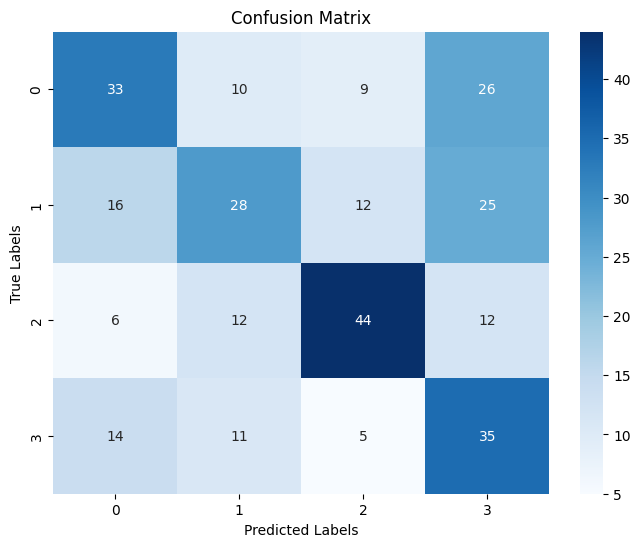

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, ParameterGrid

def custom_scorer(estimator, X, y, batch_size):
    deb_val, n2v_val = X
    y_val = y
    criterion = nn.CrossEntropyLoss()

    _, val_acc = validate_model(estimator, criterion, deb_val, n2v_val, y_val, batch_size)
    return val_acc

def model_fit_predict(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid, cv=3):
    best_score = 0.0
    best_params = None

    for params in ParameterGrid(param_grid):
        # Split the training data into training and validation sets
        deb_train_split, deb_val_split, n2v_train_split, n2v_val_split, y_train_split, y_val_split = train_test_split(
            deb_train, n2v_train, y_train, test_size=0.2, random_state=42
        )

        model = TextClassificationModel(
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        )

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_model(model, criterion, optimizer, deb_train_split, n2v_train_split, y_train_split, deb_val_split, n2v_val_split, y_val_split, params['batch_size'], params['num_epochs'])

        score = custom_scorer(model, (deb_val_split, n2v_val_split), y_val_split, params['batch_size'])
        if score > best_score:
            best_score = score
            best_params = params

    print(f'Best parameters: {best_params}')
    print(f'Best validation accuracy: {best_score:.4f}')

    best_model = TextClassificationModel(
        hidden_size=best_params['hidden_size'],
        num_layers=best_params['num_layers'],
        dropout=best_params['dropout']
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
    train_model(best_model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, best_params['batch_size'], best_params['num_epochs'])

    test_model(best_model, deb_test, n2v_test, y_test, best_params['batch_size'])

# Define hyperparameter grid
param_grid = {
    'hidden_size': [256, 512],
    'num_layers': [3, 4],
    'dropout': [0.1, 0.2],
    'lr': [0.0001, 0.0003],
    'num_epochs': [30, 40],
    'batch_size': [24]
}

# Perform grid search
model_fit_predict(deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, param_grid)


* M1 - BiLSTM + Deb - 72% or more
* M2 - BiGRU + Deb - 73% or more
* M3 - BiLSTM + Deb + N2v - 71% or more
* M4 - BiGRU + Deb + N2v - 72% or more

Length 64
* M1 - BiLSTM + Deb - 74% or more
* M2 - BiGRU + Deb - 76% or more
* M3 - BiLSTM + Deb + N2v - 68% or more
* M4 - BiGRU + Deb + N2v - 70% or more

M1:
* 40 epochs: 76% ac lr 0.0003 weight_decay=0.0002
M3 fara wd si cu batch size 24



100%|██████████| 40/40 [02:22<00:00,  3.55s/it, Validation Loss:=2.5799, Validation Accuracy:=0.4430]


Accuracy: 0.4430
Precision: [0.52830189 0.40298507 0.46280992 0.36842105]
Recall: [0.35897436 0.33333333 0.75675676 0.32307692]
F1 Score: [0.42748092 0.36486486 0.57435897 0.3442623 ]


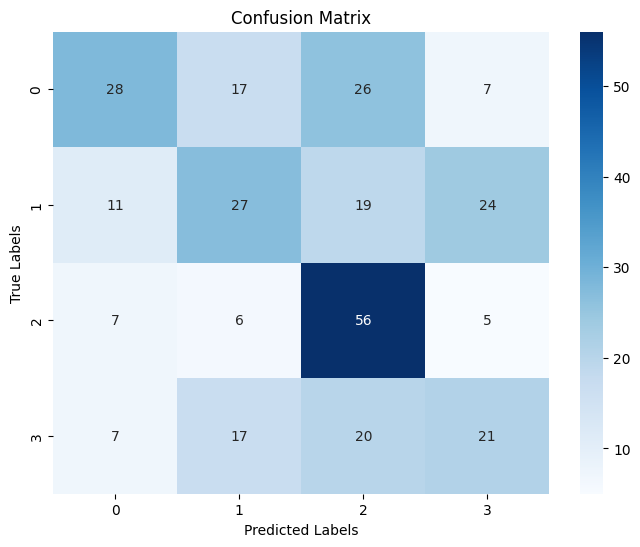

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

# model = TextClassificationModel4()
#model =  TextClassificationModel()
model =  TextClassificationModel(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )
#model =  TextClassificationModel3()
# model =  TextClassificationModel4()
model.to("cuda")
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay = 0.0002)

#scheduler = StepLR(optimizer, step_size=10, gamma=0.3)

#for epoch in range(4):
#train_model(model, criterion, optimizer, deb_train, n2v_train, y_train, deb_test, n2v_test, y_test, batch_size, num_epochs)
train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)
    #scheduler.step()  # Update the learning rate
    #print(f"Epoch {epoch+1}/{num_epochs}, Current Learning Rate: {scheduler.get_last_lr()}")

test_model(model, glov_test, n2v_test, y_test, batch_size)
# test_model(model, deb_train, n2v_train, y_train, batch_size)

100%|██████████| 40/40 [03:12<00:00,  4.81s/it, Validation Loss:=1.4730, Validation Accuracy:=0.6510]


Accuracy: 0.6510
Precision: [0.78947368 0.6        0.66666667 0.56666667]
Recall: [0.57692308 0.62962963 0.86486486 0.52307692]
F1 Score: [0.66666667 0.61445783 0.75294118 0.544     ]


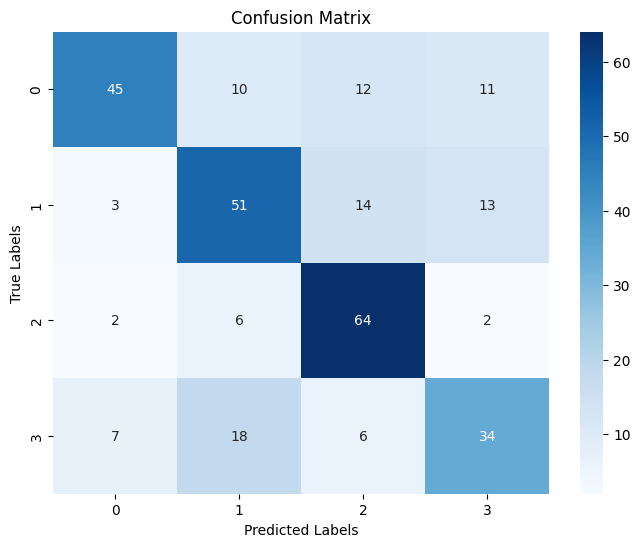

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

model =  TextClassificationModel2(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)

test_model(model, glov_test, n2v_test, y_test, batch_size)


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 40/40 [02:17<00:00,  3.44s/it, Validation Loss:=1.4826, Validation Accuracy:=0.5268]


Accuracy: 0.5268
Precision: [0.475      0.61818182 0.6        0.3968254 ]
Recall: [0.48717949 0.41975309 0.81081081 0.38461538]
F1 Score: [0.48101266 0.5        0.68965517 0.390625  ]


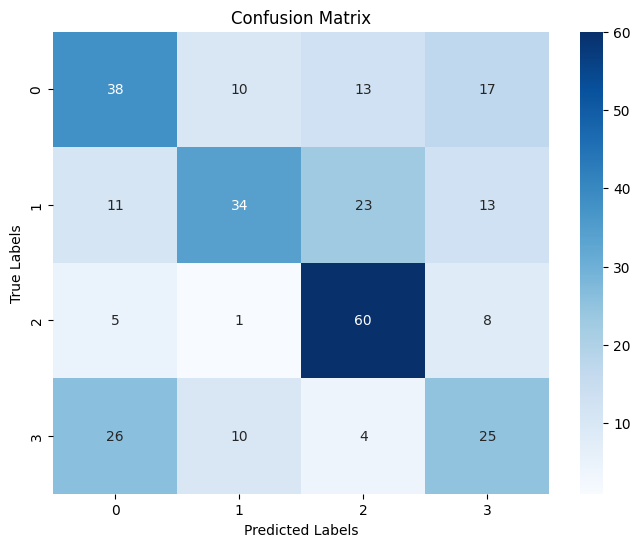

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

model =  TextClassificationModel3(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)

test_model(model, glov_test, n2v_test, y_test, batch_size)


100%|██████████| 40/40 [03:24<00:00,  5.12s/it, Validation Loss:=2.4063, Validation Accuracy:=0.5537]


Accuracy: 0.5537
Precision: [0.55813953 0.54098361 0.64634146 0.44927536]
Recall: [0.61538462 0.40740741 0.71621622 0.47692308]
F1 Score: [0.58536585 0.46478873 0.67948718 0.46268657]


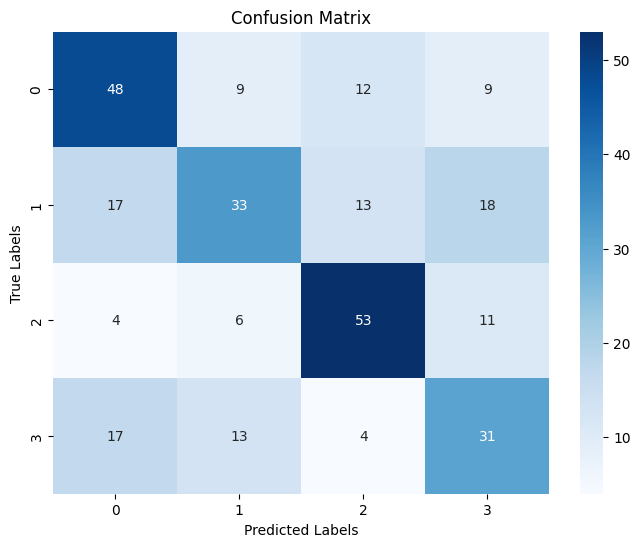

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

model =  TextClassificationModel4(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)

test_model(model, glov_test, n2v_test, y_test, batch_size)


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 40/40 [00:43<00:00,  1.08s/it, Validation Loss:=2.1527, Validation Accuracy:=0.5134]


Accuracy: 0.5134
Precision: [0.36507937 0.44705882 0.87272727 0.65625   ]
Recall: [0.58974359 0.4691358  0.64864865 0.32307692]
F1 Score: [0.45098039 0.45783133 0.74418605 0.43298969]


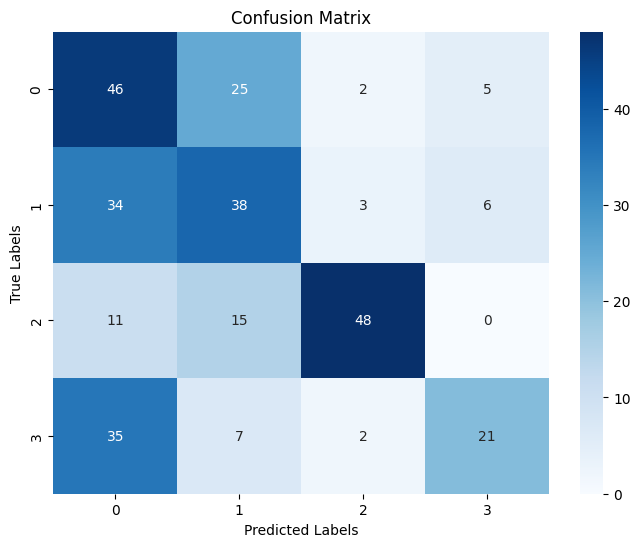

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

model =  TextClassificationModel5(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)

test_model(model, glov_test, n2v_test, y_test, batch_size)


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 40/40 [00:42<00:00,  1.06s/it, Validation Loss:=2.3276, Validation Accuracy:=0.4430]


Accuracy: 0.4430
Precision: [0.93333333 0.3364486  0.93333333 0.30534351]
Recall: [0.17948718 0.44444444 0.56756757 0.61538462]
F1 Score: [0.30107527 0.38297872 0.70588235 0.40816327]


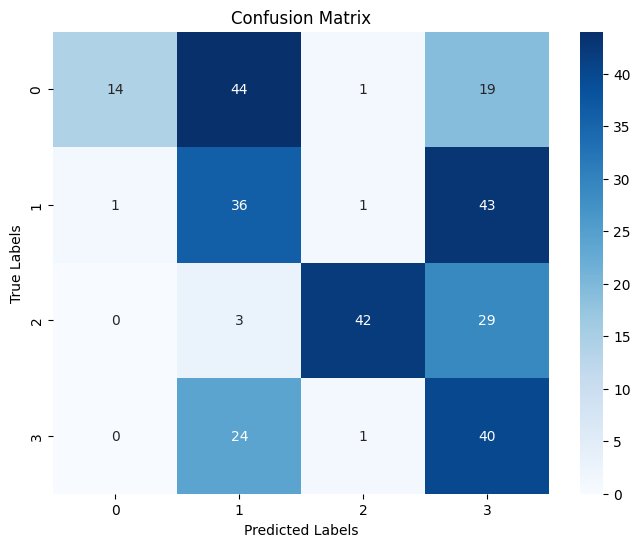

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

model =  TextClassificationModel6(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)

test_model(model, glov_test, n2v_test, y_test, batch_size)


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 40/40 [00:57<00:00,  1.43s/it, Validation Loss:=2.0141, Validation Accuracy:=0.4866]


Accuracy: 0.4866
Precision: [0.38655462 0.70588235 0.49137931 0.62068966]
Recall: [0.58974359 0.2962963  0.77027027 0.27692308]
F1 Score: [0.46700508 0.4173913  0.6        0.38297872]


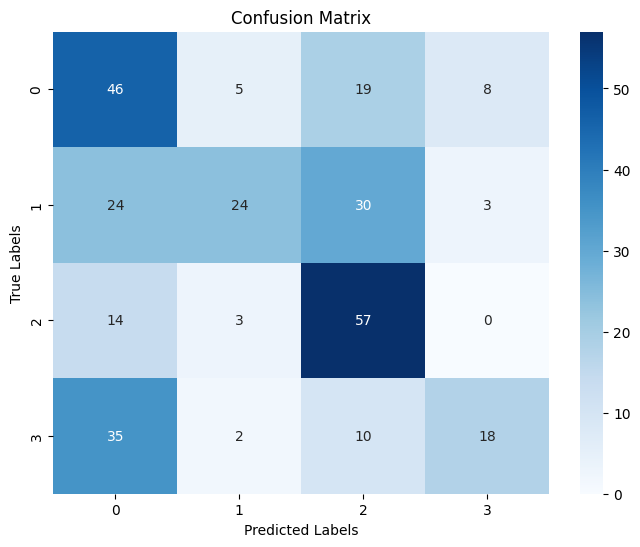

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

model =  TextClassificationModel7(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)

test_model(model, glov_test, n2v_test, y_test, batch_size)


100%|██████████| 40/40 [01:09<00:00,  1.73s/it, Validation Loss:=2.1616, Validation Accuracy:=0.6107]


Accuracy: 0.6107
Precision: [0.6        0.53043478 0.70786517 0.64102564]
Recall: [0.42307692 0.75308642 0.85135135 0.38461538]
F1 Score: [0.4962406  0.62244898 0.77300613 0.48076923]


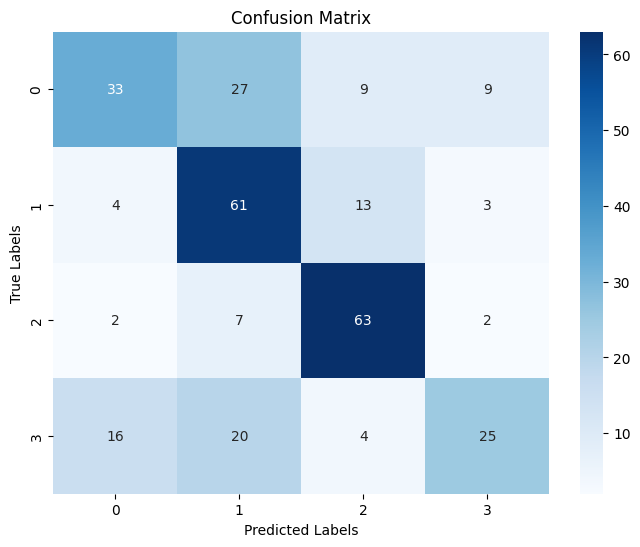

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
num_epochs = 40
batch_size = 32

model =  TextClassificationModel8(
        hidden_size=512,
        num_layers=4,
        dropout=0.2
    )

model.to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, criterion, optimizer, glov_train, n2v_train, y_train, glov_test, n2v_test, y_test, 24, 40)

test_model(model, glov_test, n2v_test, y_test, batch_size)
